In [1]:
import warnings
warnings.simplefilter("ignore")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter
import sys
import tensorflow_probability as tfp
import time
from pyDOE import lhs
from scipy.io import savemat
from scipy.fft import fft, fftfreq

In [7]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, t_u, x_u, layers, kappa, lt, ut, acts=0):

        self.scale = tf.reduce_max(tf.abs(x_u)) / 2
        x_u2 = x_u / self.scale
        actv = [tf.tanh, tf.sin]

        self.t_u = t_u
        self.x_u = x_u2
        self.datatype = t_u.dtype

        self.lt = lt
        self.ut = ut

        self.layers = layers
        self.kappa = kappa

        # determine the activation function to use
        self.actv = actv[acts]

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be
        #            automatically updated in the original tf.Variable

        # define the loss function
        self.loss0 = self.scale ** 2
        self.loss = []
        self.loss_0 = self.loss_NN()

        self.optimizer_Adam = tf.optimizers.Adam()

    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)

        for l in range(0, num_layers - 1):
            W = self.MPL_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=self.datatype))
            weights.append(W)
            biases.append(b)
        return weights, biases

    def MPL_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.datatype))

    def get_params(self):
        return (self.weights, self.biases)

    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''

    def neural_net(self, X):
        weights = self.weights
        biases = self.biases

        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lt) / (self.ut - self.lt) - 1.0

        W = weights[0]
        b = biases[0]
        H = self.actv(tf.add(self.kappa * tf.matmul(H, W), b))

        for l in range(1, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.x_pred = self.neural_net(self.t_u)
        loss = tf.reduce_mean(tf.square(self.x_u - self.x_pred))
        return loss

    '''
    Functions used to define ADAM optimizers
    ===============================================================
    '''

    # define the function to apply the ADAM optimizer
    def adam_function(self):
        @tf.function
        def f():
            # calculate the loss
            loss_norm = self.loss_NN()
            loss_value = loss_norm * self.loss0
            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: Adam", "Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 10 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )
            return loss_norm

        f.iter = tf.Variable(0)
        f.term = []
        f.loss = []
        return f

    def Adam_optimizer(self, nIter):
        varlist = self.train_variables
        func_adam = self.adam_function()
        for it in range(nIter):
            tf.keras.optimizers.Adam(func_adam, varlist)
            #self.optimizer_Adam.minimize(func_adam, varlist)
        return func_adam

    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''

    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self, varlist):
        # obtain the shapes of all trainable parameters in the model
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = []  # stitch indices
        part = []  # partition indices

        for i, shape in enumerate(shapes):
            n = np.prod(shape)
            idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
            part.extend([i] * n)
            count += n

        part = tf.constant(part)

        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self

            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                varlist[i].assign(tf.reshape(param, shape))

        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self

            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_norm = self.loss_NN()
                loss_value = loss_norm * self.loss0

            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_norm, varlist)
            grads = tf.dynamic_stitch(idx, grads)

            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: LBFGS", "Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 3000 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )

            return loss_value, grads

        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.loss = []

        return f

    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter, varlist):

        func = self.Lbfgs_function(varlist)

        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, varlist)

        max_nIter = tf.cast(nIter / 3, dtype=tf.int32)

        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params,
            tolerance=1e-11, max_iterations=max_nIter)

        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)

        return func

    '''
    Function used for training the model
    ===============================================================
    '''

    def train(self, nIter, idxOpt):
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            func_adam = self.Adam_optimizer(nIter)
            self.loss += func_adam.loss
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            func_bfgs = self.Lbfgs_optimizer(nIter, self.train_variables)
            self.loss += func_bfgs.loss

    # @tf.function
    def predict(self, t):
        x_p = self.neural_net(t) * self.scale
        return x_p

    


In [8]:
np.random.seed(234)
tf.random.set_seed(234)

N_eval = 8000
layers = [1, 20, 20, 20, 1]
layers2 = [1, 30, 30, 30, 1]
kappa = 1


def fun_test(t):
    # customize the function by the user
    x = (t ** 3) / (0.01 + t ** 4) # example 2
    #x = tf.math.log(t+2) * tf.cos(2*t + t**3)   # example 1
    # x = tf.sin(2*t+1) + 0.2*tf.exp(1.3*t)  # example 2
    return x


t = np.linspace(-1.02, 1.02, 1501)[:, None]
t_train = tf.cast(t, dtype=tf.float64)
x_train = fun_test(t_train)

# Domain bounds
lt = t.min(0)
ut = t.max(0)

t_eval = np.linspace(-1, 1, N_eval)[:, None]
t_eval = tf.cast(t_eval, dtype=tf.float64)
x_eval = fun_test(t_eval)

'''
First stage of training
'''
# acts = 0 indicates selecting tanh as the activation function
model = PhysicsInformedNN(t_train, x_train, layers, kappa, lt, ut, acts=0)
# start the first stage training
model.train(3000, 1)     # mode 1 use Adam
model.train(10000, 2)    # mode 2 use L-bfgs
x_pred = model.predict(t_eval)
######################################################################

Mode: LBFGSIter: 3000, loss: 2.0082e-05
Mode: LBFGSIter: 6000, loss: 2.0671e-07
Mode: LBFGSIter: 9000, loss: 1.4526e-07


In [9]:
x_train2 = x_train - model.predict(t_train)
print(x_train2)

tf.Tensor(
[[ 0.00101168]
 [ 0.00097397]
 [ 0.00093686]
 ...
 [-0.00117567]
 [-0.00122876]
 [-0.00128275]], shape=(1501, 1), dtype=float64)


In [86]:

'''
Second stage of training
'''
# calculate the residue for the second stage
x_train2 = x_train - model.predict(t_train)


###############################################
# Calculate dominant frequency
g = x_train2.numpy().flatten()
N = len(g)
# Total time range
total_time_range = 2  # from -1 to 1

# Calculate the sample rate
sample_rate = N / total_time_range
print(f"Sample Rate: {sample_rate} Hz")

# Perform FFT
T = 1.0 / sample_rate
yf1 = fft(g)
xf1 = fftfreq(N, T)[:N//2]

# Identify the dominant frequency
dominant_freq_idx = np.argmax(np.abs(yf1[:N//2]))
dominant_freq = xf1[dominant_freq_idx]
magnitude = np.abs(yf1[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")
kappa2f =  2 * np.pi * dominant_freq
print(f"kappa2f: {kappa2f}")
######################################################

# get the scale factor approximately by finding the number of zeros of the residues)
# (more official way is to use the fourier transform and get dominant frequency)
idxZero = np.where(x_train2[0:-1, 0] * x_train2[1:, 0] < 0)[0]
NumZero = idxZero.shape[0]
kappa2 = 3*NumZero
print(f"kappa2: {kappa2}")
# (acts = 1 indicates selecting sin as the activation function)
model2 = PhysicsInformedNN(t_train, x_train2, layers, kappa2f, lt, ut, acts=1)
# start the second stage training
model2.train(5000, 1)    # mode 1 use Adam
model2.train(20000, 2)   # mode 2 use L-bfgs
x_pred2 = model2.predict(t_eval)
# combining the result from first and second stage
x_p = x_pred + x_pred2

Sample Rate: 750.5 Hz
Dominant Frequency: 4.0 Hz
kappa2f: 25.132741228718345
kappa2: 57
Mode: LBFGSIter: 3000, loss: 4.1405e-12
Mode: LBFGSIter: 6000, loss: 1.1285e-12
Mode: LBFGSIter: 9000, loss: 5.7004e-13
Mode: LBFGSIter: 12000, loss: 2.7809e-13
Mode: LBFGSIter: 15000, loss: 1.3495e-13
Mode: LBFGSIter: 18000, loss: 9.8545e-14


In [87]:
'''
Third stage of training
'''
# increase the data points for the third stage (assuming it is available)
t2 = np.linspace(-1.02, 1.02, 4801)[:, None]
t_train2 = tf.cast(t2, dtype=tf.float64)
x_train = fun_test(t_train2)
# calculate the residue for the third stage
x_train3 = x_train - model.predict(t_train2) - model2.predict(t_train2)


###############################################
# Calculate dominant frequency
g = x_train3.numpy().flatten()
N = len(g)
# Total time range
total_time_range = 2  # from -1 to 1

# Calculate the sample rate
sample_rate = N / total_time_range
print(f"Sample Rate: {sample_rate} Hz")

# Perform FFT
T = 1.0 / sample_rate
yf2 = fft(g)
xf2 = fftfreq(N, T)[:N//2]

# Identify the dominant frequency
dominant_freq_idx = np.argmax(np.abs(yf2[:N//2]))
dominant_freq = xf2[dominant_freq_idx]
magnitude = np.abs(yf2[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")
kappa3f =  2 * np.pi * dominant_freq
print(f"kappa3f: {kappa3f}")
######################################################



# get the scale factor approximately by finding the number of zeros of the residues)
idxZero = np.where(x_train3[0:-1, 0] * x_train3[1:, 0] < 0)[0]
NumZero2 = idxZero.shape[0]
kappa3 = 3*NumZero2
print(kappa3)

# (acts = 1 indicates selecting sin as the activation function)
model3 = PhysicsInformedNN(t_train2, x_train3, layers2, kappa3f, lt, ut, acts=1)
# start the third stage training
model3.train(5000, 1)      # mode 1 use Adam
model3.train(30000, 2)     # mode 2 use L-bfgs
x_pred3 = model3.predict(t_eval)
# combining the result from first, second and third stages
x_p2 = x_pred + x_pred2 + x_pred3

Sample Rate: 2400.5 Hz
Dominant Frequency: 22.5 Hz
kappa3f: 141.3716694115407
261
Mode: LBFGSIter: 3000, loss: 1.5640e-16
Mode: LBFGSIter: 6000, loss: 2.7530e-17
Mode: LBFGSIter: 9000, loss: 9.9300e-18
Mode: LBFGSIter: 12000, loss: 5.3687e-18
Mode: LBFGSIter: 15000, loss: 2.7961e-18
Mode: LBFGSIter: 18000, loss: 1.7731e-18
Mode: LBFGSIter: 21000, loss: 1.2349e-18
Mode: LBFGSIter: 24000, loss: 9.2250e-19
Mode: LBFGSIter: 27000, loss: 7.1318e-19


In [88]:

'''
Forth stage of training
'''
# calculate the residue for the forth stage
x_train4 = x_train - model.predict(t_train2) - model2.predict(t_train2) - model3.predict(t_train2)


###############################################
# Calculate dominant frequency
g = x_train4.numpy().flatten()
N = len(g)
# Total time range
total_time_range = 2  # from -1 to 1

# Calculate the sample rate
sample_rate = N / total_time_range
print(f"Sample Rate: {sample_rate} Hz")

# Perform FFT
T = 1.0 / sample_rate
yf4 = fft(g)
xf4 = fftfreq(N, T)[:N//2]

# Identify the dominant frequency
dominant_freq_idx = np.argmax(np.abs(yf4[:N//2]))
dominant_freq = xf4[dominant_freq_idx]
magnitude = np.abs(yf4[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")
kappa4f =  2 * np.pi * dominant_freq
print(f"kappa4f: {kappa4f}")
######################################################


# get the scale factor approximately by finding the number of zeros of the residues)
idxZero = np.where(x_train4[0:-1, 0] * x_train4[1:, 0] < 0)[0]
NumZero3 = idxZero.shape[0]
kappa4 = 3*NumZero3

# (acts = 1 indicates selecting sin as the activation function)
model4 = PhysicsInformedNN(t_train2, x_train4, layers2, kappa4f, lt, ut)
# start the forth stage training
model4.train(5000, 1)
model4.train(40000, 2)
x_pred4 = model4.predict(t_eval)
# combining the result from all stages
x_p3 = x_pred + x_pred2 + x_pred3 + x_pred4



Sample Rate: 2400.5 Hz
Dominant Frequency: 184.0 Hz
kappa4f: 1156.1060965210438
Mode: LBFGSIter: 3000, loss: 5.8218e-19
Mode: LBFGSIter: 6000, loss: 5.8191e-19
Mode: LBFGSIter: 9000, loss: 5.8180e-19
Mode: LBFGSIter: 12000, loss: 5.8176e-19
Mode: LBFGSIter: 15000, loss: 5.8175e-19
Mode: LBFGSIter: 18000, loss: 5.8174e-19
Mode: LBFGSIter: 21000, loss: 5.8172e-19
Mode: LBFGSIter: 24000, loss: 5.8172e-19
Mode: LBFGSIter: 27000, loss: 5.8171e-19
Mode: LBFGSIter: 30000, loss: 5.8170e-19
Mode: LBFGSIter: 33000, loss: 5.8169e-19
Mode: LBFGSIter: 36000, loss: 5.8169e-19


In [89]:
#%%
# combine the loss of all four stages of training
loss = np.array(model.loss + model2.loss + model3.loss + model4.loss)

residue = x_train4 - model4.predict(t_train2)

error_x = np.linalg.norm(x_eval-x_pred, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))

error_x2 = np.linalg.norm(x_eval-x_p, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x2))

error_x3 = np.linalg.norm(x_eval-x_p2, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x3))

error_x4 = np.linalg.norm(x_eval-x_p3, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x4))

mdic = {"t": t_eval.numpy(), "x_g": x_eval.numpy(), "x0": x_pred.numpy(),
        "x1": x_pred2.numpy(), "x2": x_pred3.numpy(), 'x3': x_pred4.numpy(),
        "err": residue.numpy(), 'loss': loss}
FileName = 'Reg_mNN_1D_64bit.mat'
savemat(FileName, mdic)

#%%

Error u: 2.823785e-04
Error u: 2.215834e-07
Error u: 5.322239e-10
Error u: 5.293627e-10


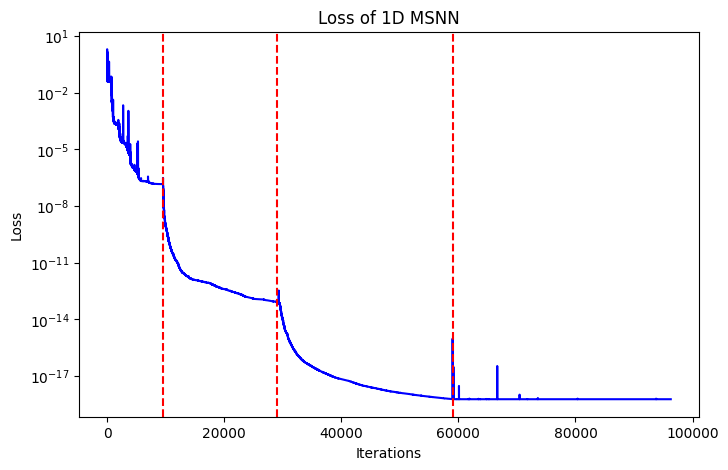

In [144]:
plt.figure(figsize=(8,5))
plt.plot(loss, 'b-')
plt.yscale("log")
plt.title("Loss of 1D MSNN")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.axvline(x=9500, linestyle='--', color='r')
plt.axvline(x=29000, linestyle='--', color='r')
plt.axvline(x=59000, linestyle='--', color='r')

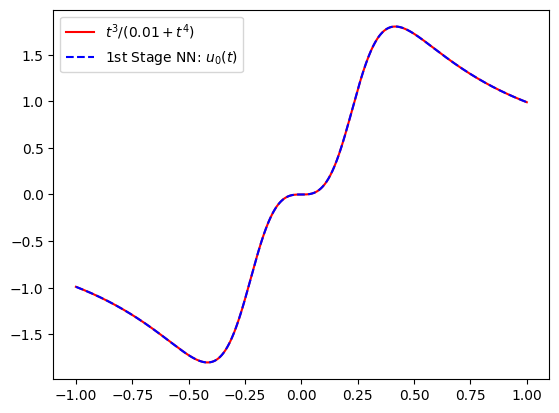

In [40]:
plt.figure()
plt.plot(t_eval, x_eval, 'r', linestyle="-", label='$t^3/(0.01 + t^4)$')
plt.plot(t_eval, x_pred, 'b', linestyle='--', label='1st Stage NN: $u_0(t)$')
plt.legend()

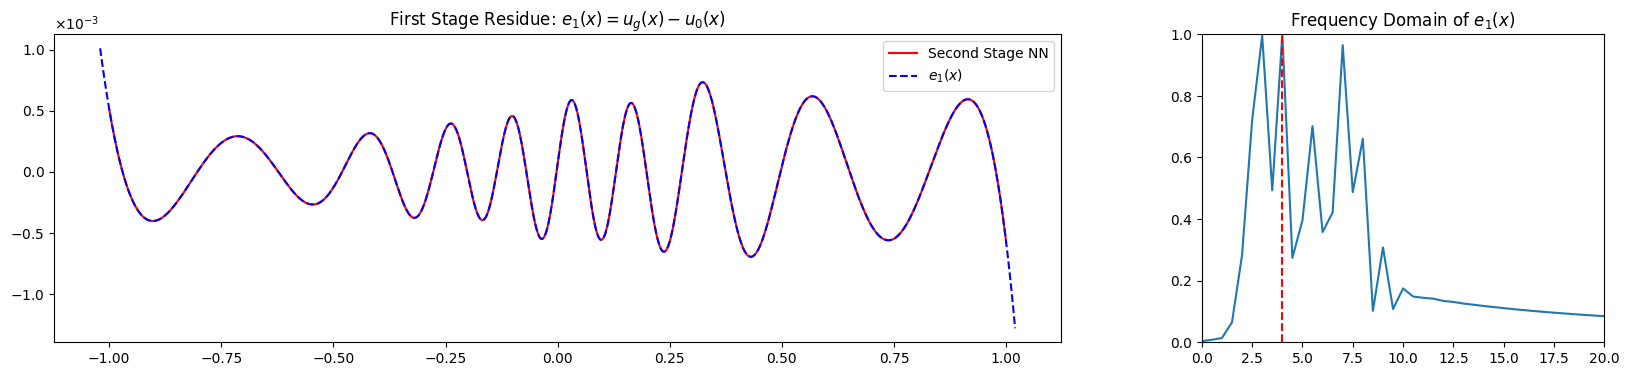

In [135]:
g = x_train2.numpy().flatten()
N = len(g)
total_time_range = 2  # from -1 to 1
sample_rate = N / total_time_range
T = 1.0 / sample_rate
yf1 = fft(g)
amplitude = 2.0 / N * np.abs(yf1[:N // 2])
amplitude /= np.max(amplitude)
xf1 = fftfreq(N, T)[:N//2]

dominant_freq_idx = np.argmax(np.abs(yf1[:N//2]))
dominant_freq = xf1[dominant_freq_idx]
magnitude = np.abs(yf1[dominant_freq_idx]) / N

fig = plt.figure(layout='constrained', figsize=(20, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[5,2])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax0.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax0.plot(t_eval, x_pred2, 'r', label='Second Stage NN')
ax0.plot(t_train, x_train2, 'b', linestyle='--', label='$e_1(x)$')
ax0.set_title("First Stage Residue: $e_1(x) = u_g(x) - u_0(x)$")
ax0.legend()
ax1 = plt.subplot(gs[1])
ax1.plot(xf1, amplitude)
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 20])
ax1.set_title("Frequency Domain of $e_1(x)$")
ax1.axvline(x=dominant_freq, linestyle='--', color='r')

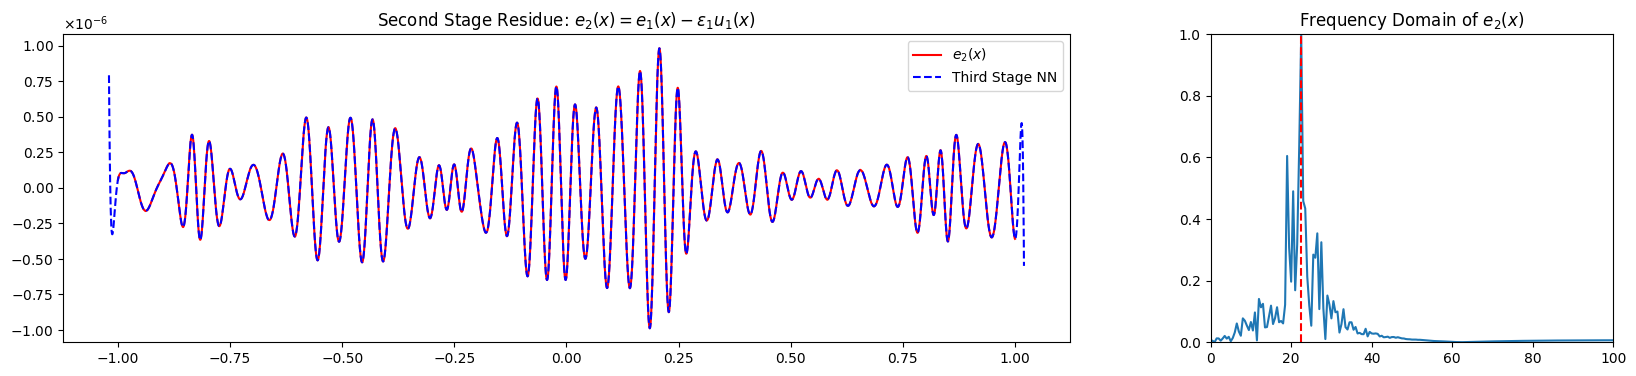

In [123]:
g = x_train3.numpy().flatten()
N = len(g)
total_time_range = 2  # from -1 to 1
sample_rate = N / total_time_range
T = 1.0 / sample_rate
yf2 = fft(g)
amplitude = 2.0 / N * np.abs(yf2[:N // 2])
amplitude /= np.max(amplitude)
xf2 = fftfreq(N, T)[:N//2]

dominant_freq_idx = np.argmax(np.abs(yf2[:N//2]))
dominant_freq = xf2[dominant_freq_idx]
magnitude = np.abs(yf2[dominant_freq_idx]) / N

fig = plt.figure(layout='constrained', figsize=(20, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[5,2])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax0.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax0.plot(t_eval, x_pred3, 'r', label='Third Stage NN')
ax0.plot(t_train2, x_train3, 'b', linestyle='--', label='$e_2(x)$')
ax0.set_title("Second Stage Residue: $e_2(x) = e_1(x) - \epsilon_1 u_1(x)$")
ax0.legend()
ax1 = plt.subplot(gs[1])
ax1.plot(xf2, amplitude)
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 100])
ax1.set_title("Frequency Domain of $e_2(x)$")
ax1.axvline(x=dominant_freq, linestyle='--', color='r')

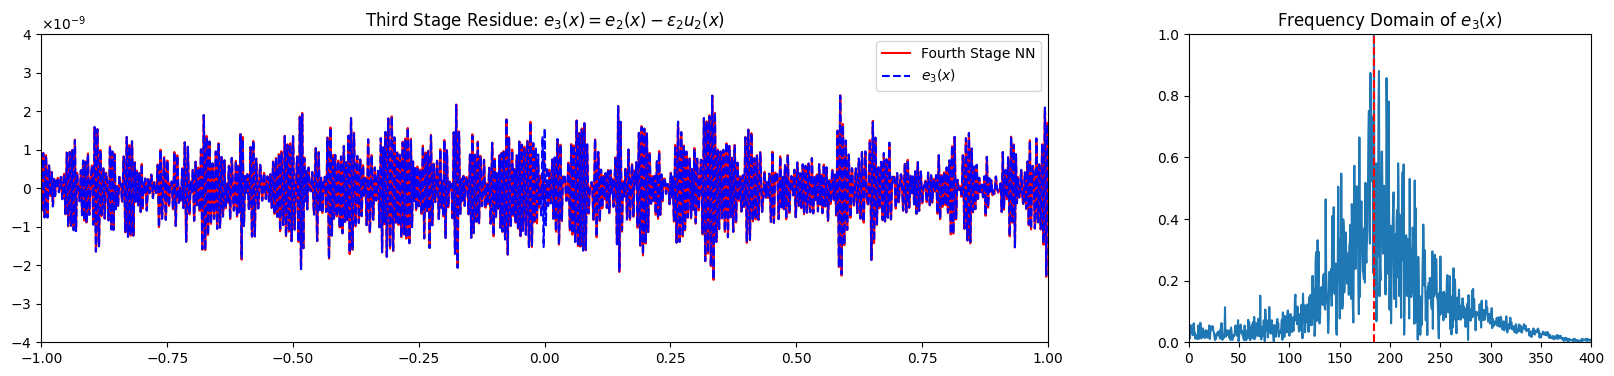

In [134]:
g = x_train4.numpy().flatten()
N = len(g)
total_time_range = 2  # from -1 to 1
sample_rate = N / total_time_range
T = 1.0 / sample_rate
yf3 = fft(g)
amplitude = 2.0 / N * np.abs(yf3[:N // 2])
amplitude /= np.max(amplitude)
xf3 = fftfreq(N, T)[:N//2]

dominant_freq_idx = np.argmax(np.abs(yf3[:N//2]))
dominant_freq = xf3[dominant_freq_idx]
magnitude = np.abs(yf3[dominant_freq_idx]) / N

res = x_eval - x_p3

fig = plt.figure(layout='constrained', figsize=(20, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[5,2])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax0.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax0.plot(t_eval, res, 'r', label='Fourth Stage NN')
ax0.plot(t_train2, x_train4, 'b', linestyle='--', label='$e_3(x)$')
ax0.set_xlim([-1, 1])
ax0.set_ylim([-4e-9, 4e-9])
ax0.set_title("Third Stage Residue: $e_3(x) = e_2(x) - \epsilon_2 u_2(x)$")
ax0.legend()
ax1 = plt.subplot(gs[1])
ax1.plot(xf3, amplitude)
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 400])
ax1.set_title("Frequency Domain of $e_3(x)$")
ax1.axvline(x=dominant_freq, linestyle='--', color='r')